<a href="https://colab.research.google.com/github/Mr-sri-ganesh/html/blob/main/SAITS(working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Colab-ready SAITS-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file, na_values=["", " "])  # 👈 This ensures empty strings become NaN
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)
    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    return norm, mask.astype(float), mean, std, df['Time'].values


def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define SAITS model (simplified self-attention-based imputer)
class SAITS(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(SAITS, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask


def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    df = pd.read_csv(test_file)
    missing = np.isnan(df['Blood Sugar Level'].values)
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]
    valid_idx = (~np.isnan(y_missing)) & (~np.isnan(p_missing))
    y_missing = y_missing[valid_idx]
    p_missing = p_missing[valid_idx]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='SAITS Imputed', color='green', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"SAITS Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_14days_sample.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = SAITS().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 SAITS Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample.csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27.csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10.csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20.csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30.csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40.csv
Epoch 20, Loss: 0.9414
Epoch 40, Loss: 1.9174
Epoch 60, Loss: 1.0184
Epoch 80, Loss: 1.1478
Epoch 100, Loss: 0.8855
Epoch 120, Loss: 1.0311
Epoch 140, Loss: 1.2569
Epoch 160, Loss: 1.0720
Epoch 180, Loss: 0.8466
Epoch 200, Loss: 0.9275
⚠️ Skipping 10% Missing – no valid missing data to evaluate.
⚠️ Skipping 20% Missing – no valid missing data to evaluate.
⚠️ Skipping 30% Missing – no valid missing data to evaluate.
⚠️ Skipping 40% Missing – no valid missing data to evaluate.

📊 SAITS Imputation Evaluation:


,Missingness,MAE,RMSE,MAPE,MAD,MRD
0,10% Missing,NaN,NaN,NaN,NaN,NaN
1,20% Missing,NaN,NaN,NaN,NaN,NaN
2,30% Missing,NaN,NaN,NaN,NaN,NaN
3,40% Missing,NaN,NaN,NaN,NaN,NaN


In [ ]:
# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Improved Data Loading
def load_and_preprocess(filepath):
    """Load and preprocess CGM data with proper datetime handling"""
    df = pd.read_csv(filepath)

    # Combine date and time into datetime
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Ensure numeric values and identify missing data
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')

    # Sort by datetime
    df = df.sort_values('DateTime')

    # Extract values and missing mask
    values = df['Blood Sugar Level'].values
    mask = ~df['Blood Sugar Level'].isna().values

    return values, mask, df['DateTime'].values

# STEP 5: Enhanced SAITS Model
class SAITS(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(SAITS, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask):
        # Create input with value and mask concatenated
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        emb = self.dropout(emb)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Improved Training with Validation
def train_model(model, train_values, train_mask, epochs=200):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Convert to tensors
    x_train = torch.FloatTensor(train_values).unsqueeze(0).unsqueeze(2).to(device)
    m_train = torch.FloatTensor(train_mask).unsqueeze(0).unsqueeze(2).to(device)

    # Create artificial missingness for training
    def create_missing_mask(original_mask, missing_prob=0.2):
        mask = original_mask.clone()
        missing = torch.rand_like(mask) < missing_prob
        mask[missing & (original_mask == 1)] = 0  # Only mask observed values
        return mask

    for epoch in range(epochs):
        # Create artificial missingness
        train_m_mask = create_missing_mask(m_train)

        # Mask input
        masked_input = x_train.clone()
        masked_input[train_m_mask == 0] = 0

        # Forward pass
        outputs = model(masked_input, train_m_mask)

        # Compute loss only on artificially masked points
        loss = criterion(outputs[train_m_mask == 0], x_train[train_m_mask == 0])

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# STEP 7: Robust Evaluation
def evaluate_imputation(model, test_file, original_values, original_mask, original_times):
    # Load test data
    test_values, test_mask, test_times = load_and_preprocess(test_file)

    # Handle case where test file might have different length
    min_len = min(len(original_values), len(test_values))
    test_values = test_values[:min_len]
    test_mask = test_mask[:min_len]
    test_times = test_times[:min_len]
    original_values = original_values[:min_len]
    original_mask = original_mask[:min_len]
    original_times = original_times[:min_len]

    # Identify truly missing points (present in original but missing in test)
    missing_points = original_mask & (~test_mask)

    if not missing_points.any():
        print("No missing data points to evaluate in this file")
        return None

    # Prepare input
    x_test = torch.FloatTensor(test_values).unsqueeze(0).unsqueeze(2).to(device)
    m_test = torch.FloatTensor(test_mask).unsqueeze(0).unsqueeze(2).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        pred = model(x_test, m_test).cpu().numpy().squeeze()

    # Calculate metrics only on missing points
    y_true = original_values[missing_points]
    y_pred = pred[missing_points]

    # Filter out any remaining NaN values
    valid_idx = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[valid_idx]
    y_pred = y_pred[valid_idx]

    if len(y_true) == 0:
        print("No valid points for evaluation after filtering")
        return None

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Visualization
    plt.figure(figsize=(14, 5))
    plt.plot(original_times, original_values, 'k-', label='Original', alpha=0.7)
    plt.plot(test_times, pred, 'g--', label='Imputed', alpha=0.7)
    plt.scatter(test_times[missing_points], original_values[missing_points],
               c='r', label='Imputed Points', s=20)
    plt.title('Glucose Level Imputation Results')
    plt.xlabel('Time')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'MAE': mae, 'RMSE': rmse, 'Num_Imputed': len(y_true)}

# STEP 8: Main Execution
if __name__ == "__main__":
    # Load complete data
    original_values, original_mask, original_times = load_and_preprocess("CGM_14days_sample.csv")

    # Train model
    model = SAITS().to(device)
    train_model(model, original_values, original_mask)

    # Evaluate on missing data files
    results = []
    for perc in [10, 20, 30, 40]:
        test_file = f"CGM_single_day_missing_{perc}.csv"
        try:
            print(f"\nEvaluating {perc}% missing data...")
            metrics = evaluate_imputation(model, test_file, original_values, original_mask, original_times)
            if metrics:
                metrics['Missingness'] = f"{perc}%"
                results.append(metrics)
        except Exception as e:
            print(f"Error evaluating {test_file}: {str(e)}")

    # Display results
    if results:
        results_df = pd.DataFrame(results)
        print("\nImputation Performance Summary:")
        print(results_df[['Missingness', 'MAE', 'RMSE', 'Num_Imputed']])
    else:
        print("No valid results were obtained from any test files")

Saving CGM_14days_sample.csv to CGM_14days_sample (1).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (1).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (1).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (1).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (1).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (1).csv


/tmp/ipython-input-2-3020094071.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


DateParseError: Unknown datetime string format, unable to parse: 14-11-A312023 11:55 PM, at position 4031

Saving CGM_14days_sample.csv to CGM_14days_sample (3).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (3).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (3).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (3).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (3).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (3).csv
Epoch 20, Loss: 0.9891
Epoch 40, Loss: 0.9962
Epoch 60, Loss: 1.2282
Epoch 80, Loss: 0.9902
Epoch 100, Loss: 1.1961
Epoch 120, Loss: 0.8338
Epoch 140, Loss: 0.8821
Epoch 160, Loss: 0.8933
Epoch 180, Loss: 1.2158
Epoch 200, Loss: 0.7674


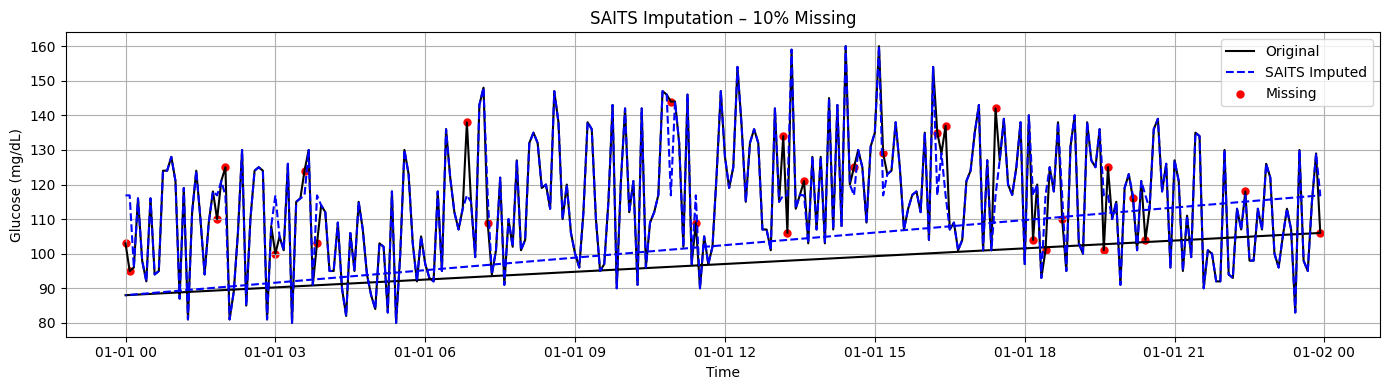

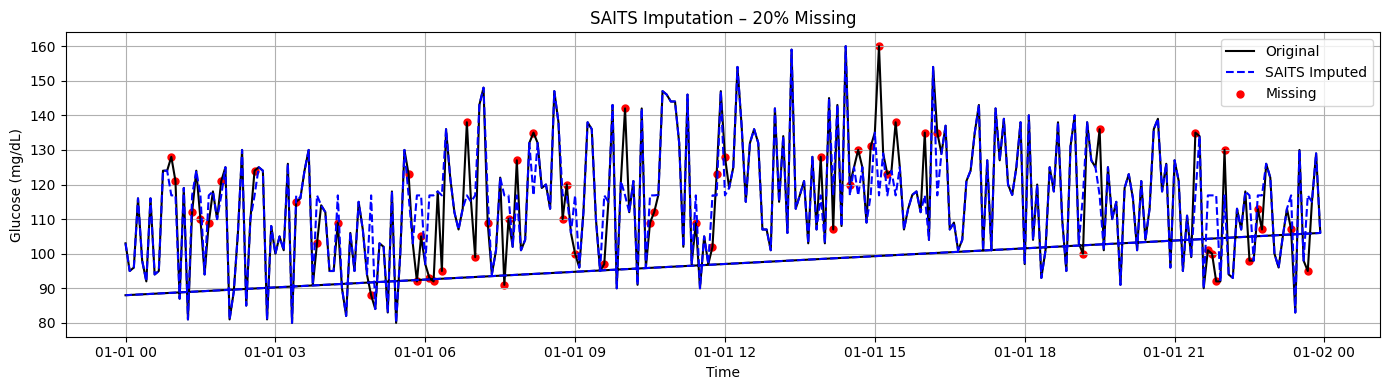

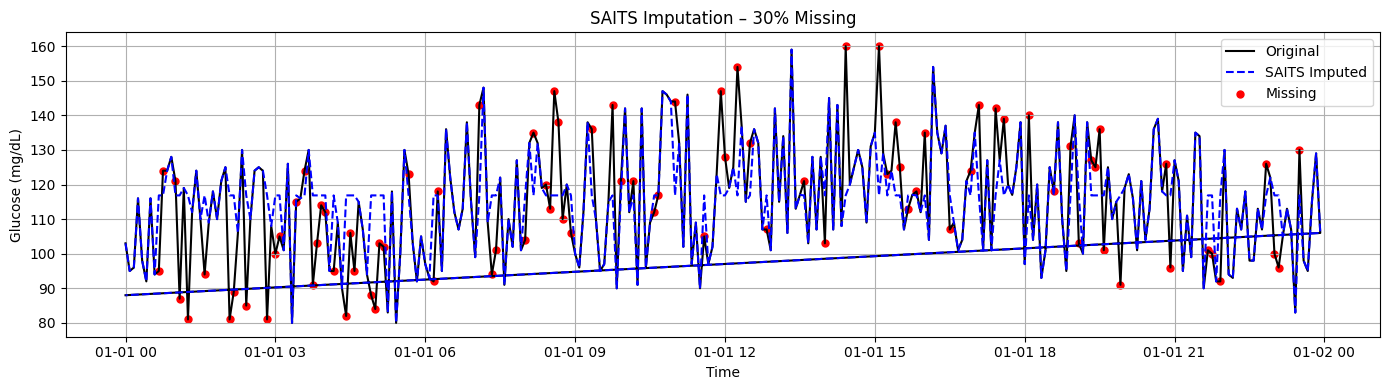

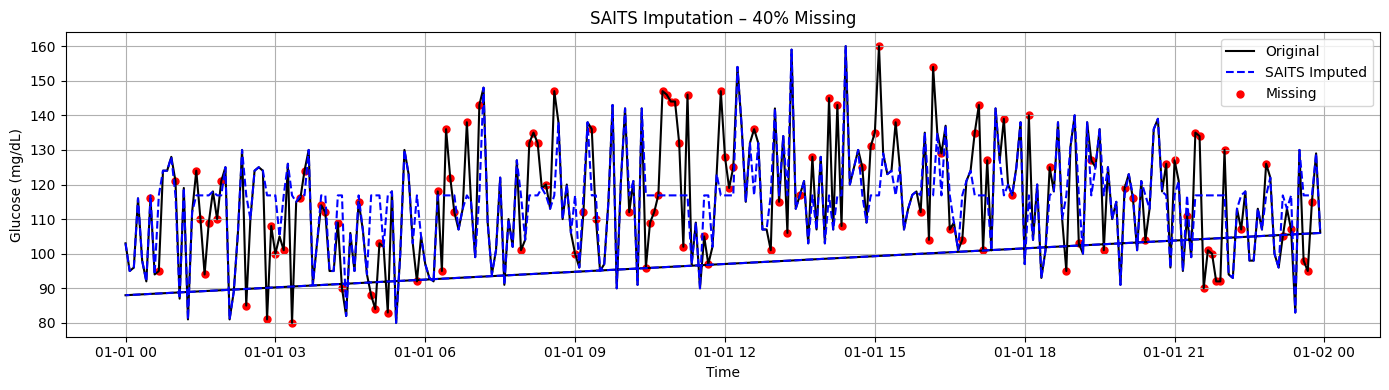


📊 SAITS Imputation Evaluation:


,Missingness,MAE,RMSE,MAPE,MAD,MRD
0,10% Missing,12.633289,14.260293,10.820150,12.633289,10.820150
1,20% Missing,13.890486,16.071935,12.535174,13.890486,12.535174
2,30% Missing,16.923563,19.966618,15.579783,16.923563,15.579783
3,40% Missing,15.119681,18.031466,13.453905,15.119681,13.453905


In [ ]:
# ✅ Colab-ready SAITS-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file)
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)

    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define SAITS model (simplified self-attention-based imputer)
class SAITS(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(SAITS, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='SAITS Imputed', color='blue', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"SAITS Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = SAITS().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 SAITS Imputation Evaluation:")
display(results_df)


Saving CGM_14days_sample.csv to CGM_14days_sample (10).csv
Saving CGM_single_day_2025-06-27.csv to CGM_single_day_2025-06-27 (10).csv
Saving CGM_single_day_missing_10.csv to CGM_single_day_missing_10 (10).csv
Saving CGM_single_day_missing_20.csv to CGM_single_day_missing_20 (10).csv
Saving CGM_single_day_missing_30.csv to CGM_single_day_missing_30 (10).csv
Saving CGM_single_day_missing_40.csv to CGM_single_day_missing_40 (10).csv
Epoch 20, Loss: 1.1408
Epoch 40, Loss: 1.2241
Epoch 60, Loss: 1.0631
Epoch 80, Loss: 1.4973
Epoch 100, Loss: 1.1769
Epoch 120, Loss: 1.1034
Epoch 140, Loss: 1.0718
Epoch 160, Loss: 1.2139
Epoch 180, Loss: 1.0998
Epoch 200, Loss: 1.1859
Skipping CGM_single_day_missing_10.csv due to evaluation error: x and y must be the same size
Skipping CGM_single_day_missing_20.csv due to evaluation error: x and y must be the same size
Skipping CGM_single_day_missing_30.csv due to evaluation error: x and y must be the same size
Skipping CGM_single_day_missing_40.csv due to ev

""


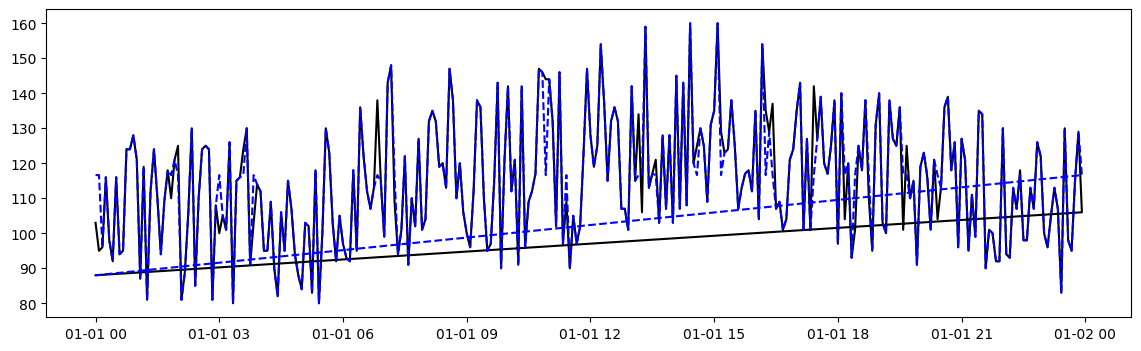

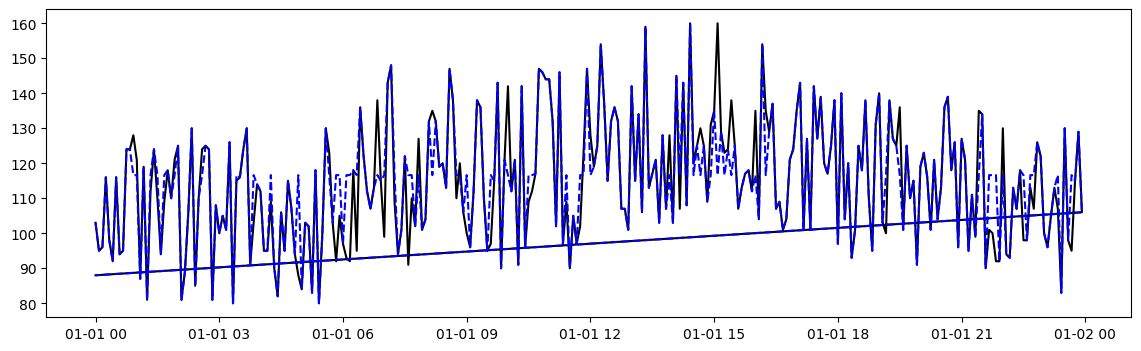

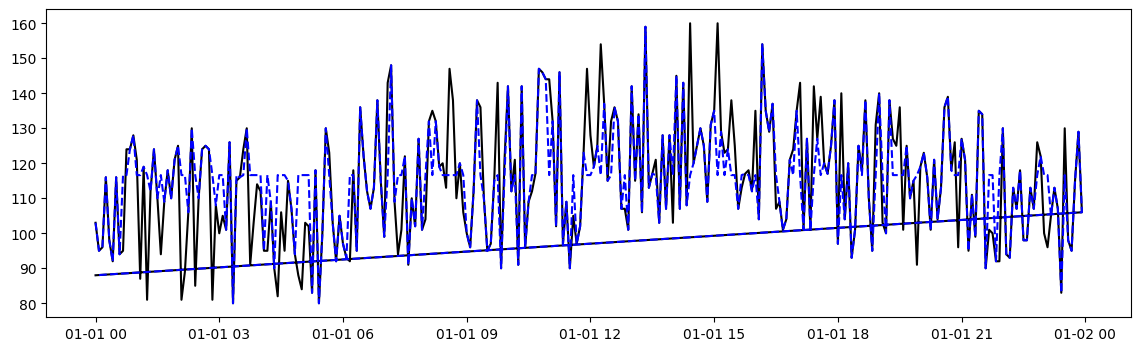

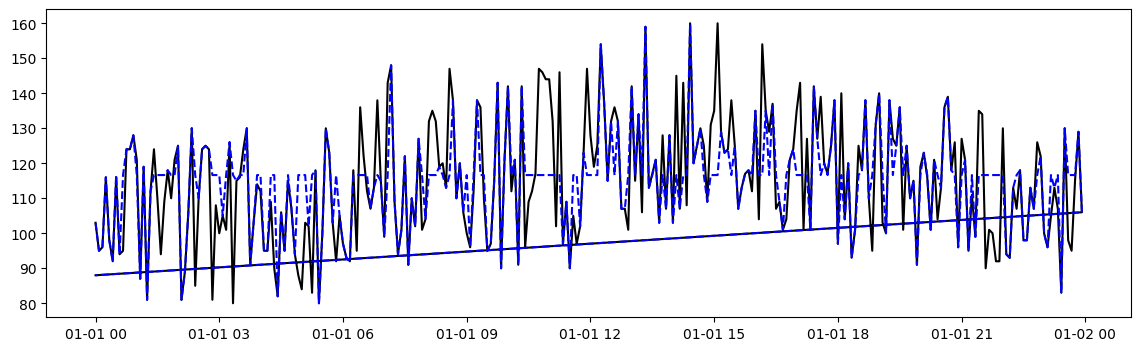

In [ ]:
# ✅ Colab-ready SAITS-based CGM Imputation (Aligned to 1-user 14-day sequence)

# STEP 1: Install packages (in Colab)

# STEP 2: Upload Files
from google.colab import files
uploaded = files.upload()

# STEP 3: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 4: Load and normalize data

def load_sequence(file, mean=None, std=None):
    df = pd.read_csv(file)
    df['Blood Sugar Level'] = pd.to_numeric(df['Blood Sugar Level'], errors='coerce')
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')

    values = df['Blood Sugar Level'].values.astype(float)
    mask = ~np.isnan(values)

    if mean is None or std is None:
        mean, std = np.nanmean(values), np.nanstd(values)
    norm = (values - mean) / std
    norm = np.nan_to_num(norm, nan=0.0)

    return norm, mask.astype(float), mean, std, df['Time'].values

def to_tensor(data, mask):
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    m = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
    return x.to(device), m.to(device)

# STEP 5: Define SAITS model (simplified self-attention-based imputer)
class SAITS(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super(SAITS, self).__init__()
        self.embedding = nn.Linear(input_size * 2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_size)

    def forward(self, x, mask):
        inp = torch.cat([x, mask], dim=2)
        emb = self.embedding(inp)
        trans_out = self.transformer(emb)
        return self.decoder(trans_out)

# STEP 6: Train function with block missingness
import random

def simulate_block_mask(mask, block_size=12):
    new_mask = mask.copy()
    for _ in range(5):
        start = random.randint(0, len(mask) - block_size)
        new_mask[start:start+block_size] = 0
    return new_mask

def train_model(model, x_full, mask_full, epochs=200):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        train_mask = mask_full.clone().squeeze(0).squeeze(1).cpu().numpy()
        train_mask = simulate_block_mask(train_mask)
        train_mask = torch.tensor(train_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        masked_input = x_full.clone()
        masked_input[train_mask == 0] = 0

        out = model(masked_input, train_mask)
        if (train_mask == 0).sum() == 0:
            continue
        loss = loss_fn(out[train_mask == 0], x_full[train_mask == 0])
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# STEP 7: Evaluate function

def evaluate(model, test_file, original_file, mean, std, label):
    x_raw, mask, _, _, time_axis = load_sequence(test_file, mean, std)
    y_true, _, _, _, _ = load_sequence(original_file, mean, std)
    x_tensor, m_tensor = to_tensor(x_raw, mask)

    model.eval()
    with torch.no_grad():
        pred = model(x_tensor, m_tensor).cpu().squeeze().numpy()

    pred = pred * std + mean
    y_true = y_true * std + mean

    missing = mask == 0
    known = ~missing

    pred[known] = y_true[known]

    y_missing = y_true[missing]
    p_missing = pred[missing]

    if len(y_missing) == 0:
        print(f"⚠️ Skipping {label} – no valid missing data to evaluate.")
        return {'Missingness': label, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'MAD': np.nan, 'MRD': np.nan}

    mae = mean_absolute_error(y_missing, p_missing)
    rmse = np.sqrt(mean_squared_error(y_missing, p_missing))
    mape = mean_absolute_percentage_error(y_missing, p_missing)
    mad = np.mean(np.abs(y_missing - p_missing))
    mrd = np.mean(np.abs((y_missing - p_missing) / y_missing))

    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, y_true, label='Original', color='black')
    plt.plot(time_axis, pred, label='SAITS Imputed', color='blue', linestyle='--')
    plt.scatter(time_axis[missing], y_true[missing], color='red', s=25, label='Missing')
    plt.title(f"SAITS Imputation – {label}")
    plt.xlabel("Time"); plt.ylabel("Glucose (mg/dL)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    return {'Missingness': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape*100, 'MAD': mad, 'MRD': mrd*100}

# STEP 8: Run Training + Imputation
train_data, train_mask, mean, std, _ = load_sequence("CGM_single_day_2025-06-27.csv")
x_train, m_train = to_tensor(train_data, train_mask)
model = SAITS().to(device)
train_model(model, x_train, m_train)

# STEP 9: Evaluate on test sets
results = []
for perc in ['10', '20', '30', '40']:
    file = f"CGM_single_day_missing_{perc}.csv"
    try:
        result = evaluate(model, file, "CGM_single_day_2025-06-27.csv", mean, std, f"{perc}% Missing")
        results.append(result)
    except ValueError as e:
        print(f"Skipping {file} due to evaluation error: {e}")

results_df = pd.DataFrame(results)
print("\n📊 SAITS Imputation Evaluation:")
display(results_df)
